In [1]:
class Matrix:
    def __init__(self, data, rows, cols):
        self.data = data
        self.rows = rows
        self.cols = cols

In [2]:
def count_comment_lines(filename):
    with open(filename, 'r') as f:
        return sum(1 for line in f if line.startswith(";;;"))

In [3]:
def count_total_lines(filename):
    with open(filename, 'r') as f:
        return sum(1 for line in f)

In [4]:
def detect_columns(filename, offset):
    with open(filename, 'r') as f:
        for _ in range(offset):
            next(f)  # skip lines
        line = next(f).strip().split()
        return len(line) - 1  # excluding the trailing "-"

In [5]:
def read_file(filename, rows, cols, offset):
    with open(filename, 'r') as f:
        for _ in range(offset):
            next(f)  # skip lines

        data = []


        for k in range(rows):

            line = next(f, None)
            if line is None:
                break
            numbers = list(map(int, line.strip().split()[:-1]))  # excluding the trailing "-"
            if len(numbers) != cols:
                break

            data.extend(numbers)

        matrix_rows = len(data) // cols
        return Matrix(data, matrix_rows, cols)

In [6]:
def intersect(row1, row2):
    """Returns True if two rows have a common '1', else False"""
    return any(a == b == 1 for a, b in zip(row1, row2))

def union(row1, row2):
    """Return the union of two rows (bitwise OR)"""
    return [a | b for a, b in zip(row1, row2)]

In [7]:
def EC(A, B, COV, offset, FILE_NAME, LOADABLE_ROWS, explored=set()):
    N = A.rows
    M = A.cols

    comment_lines = count_comment_lines(FILE_NAME)


    for i in range(N):
        row_data = A.data[i * M:i * M + M] 


        # To keep the corrispondence between the rows of A
        # and the columns of B, 
        # the column B[:,i+offset] is put to 0
        # and the row B[i+offset,:] is put to 0
        if sum(row_data) == 0:
            for t in range(N):
                B[t][i+offset] = 0
                B[i+offset][t] = 0

            # Print B
            # print("B got a zero row/column")
            # print(B)
            continue

        if sum(row_data) == M:
            for t in range(N):
                B[t][i+offset] = 0
                B[i+offset][t] = 0
            # print("B got a zero row/column")
            # print(B)
            COV.add((offset + i,))
            continue

        # Iterate over previous rows of A in chunks
        reading_offset = 0
        # print("start while outside")
        while reading_offset < i + offset:
            # print("start while inside")
            old_A = read_file(FILE_NAME, LOADABLE_ROWS, M, reading_offset+comment_lines)
            # Logically, the for would be from 0 to i+offset excluded,
            # so we need to ignore all j greater than i+offset
            for j in range(min(old_A.rows, i + offset - reading_offset)):
                # if j + reading_offset >= i + offset:
                #     print("breaking since j + reading_offset >= i + offset")
                #     break
                
                # if old_A.data[j * M:j * M + M] is all zeros or all ones
                # then we can skip this row
                if sum(old_A.data[j * M:j * M + M]) == 0 or sum(old_A.data[j * M:j * M + M]) == M:
                    continue

                if intersect(old_A.data[j * M:j * M + M], row_data):
                    B[j + reading_offset][i + offset] = 0
                else:
                    I = {offset + i, j + reading_offset}
                    U = union(old_A.data[j * M:j * M + M], row_data)
                    if sum(U) == M:
                        COV.add(tuple(sorted(I)))
                        B[j + reading_offset][i + offset] = 0
                    else:
                        B[j + reading_offset][i + offset] = 1
                        inter = [k for k in range(j + reading_offset) if B[k][i + offset] and B[k][j + reading_offset]]
                        if inter:
                            explore(I, U, inter, COV, B, offset, old_A.cols, FILE_NAME, LOADABLE_ROWS, explored)

            reading_offset += LOADABLE_ROWS
            # print("end while inside")
        # print("end while outside")

    return COV


def explore(I, U, inter, COV, B, offset, M, FILE_NAME, LOADABLE_ROWS, explored=set()):
    # print("Exploring")
    # print("I: ", I)
    if I in explored:
        print("Already explored")
        return
    explored.add(tuple(sorted(I)))
    comment_lines = count_comment_lines(FILE_NAME)
    for k in inter:
        i_temp = I.union({k})
        
        # Get the data corresponding to row 'k' from the file
        chunk_index = (k // LOADABLE_ROWS) * LOADABLE_ROWS
        chunk = read_file(FILE_NAME, LOADABLE_ROWS, M, chunk_index + comment_lines)
        row_data = chunk.data[(k % LOADABLE_ROWS) * M:(k % LOADABLE_ROWS + 1) * M]
        
        u_temp = union(U, row_data)
        if sum(u_temp) == M:
            COV.add(tuple(sorted(i_temp)))
        else:
            inter_temp = [l for l in inter if l < k and B[l][k]]
            if inter_temp:
                explore(i_temp, u_temp, inter_temp, COV, B, offset, M, FILE_NAME, LOADABLE_ROWS, explored)


In [8]:
# Testing how set changes when passed to a function and updated
def test_set(s):
    s.update({1, 2, 3, 6, 7})

s = set({1,2,3,4,5})
test_set(s)
s

{1, 2, 3, 4, 5, 6, 7}

In [9]:
def incremental_process(A, B, COV, offset, FILE_NAME, LOADABLE_ROWS, explored=set()):
    
    # Find exact covers within the new chunk
    chunk_COV = EC(A, B, set(), offset, FILE_NAME, LOADABLE_ROWS, explored)
    # print("Chunk COV:", chunk_COV)
    COV.update(chunk_COV)

    return COV

In [10]:
# Creating a function that takes a filename and a number of loadable rows
# and solves the exact cover problem incrementally:

def incremental_exact_cover(filename, loadable_rows, verbose=False, explored=set()):

    # Counting the comments
    comment_lines = count_comment_lines(filename)
    
    # Detecting the number of columns
    n_columns = detect_columns(filename, comment_lines)
    print(f"Total columns: {n_columns}")

    # Counting the total number of rows
    total_rows = count_total_lines(filename) - comment_lines
    print(f"Total rows: {total_rows}")

    # Initializing the matrix B
    B = [[0] * total_rows for _ in range(total_rows)]

    # Initializing the set of visited nodes
    explored = set()

    # Initializing the set of partitions (solutions)
    COV = set()

    # Initializing the offset
    offset = 0

    while True:
        matrix = read_file(filename, loadable_rows, n_columns, offset+comment_lines)
        if not matrix.data:
            break

        if verbose:
            print("Portion of A read: from row", offset+1, "to row", offset+matrix.rows)
        # for i in range(matrix.rows):
        #     print(matrix.data[i * matrix.cols:i * matrix.cols + matrix.cols])
        # print("Found complete sets:", matrix.ones)

        incremental_process(matrix, B, COV, offset, filename, loadable_rows, explored)

        if verbose:
            print("Explored:", len(explored))

            print("B:")
            for row in B:
                print(row)

            print("COV:")
            print(COV)

        offset += matrix.rows

    print("Explored:", len(explored))

    print("Solutions:", len(COV))

    # print("B:")
    # for row in B:
    #     print(row)

    # print("COV:")
    # print(COV)

    return COV, explored

When `loadable_rows` is large the number of times the while loop is executed as a whole is the same
as when the `loadable_rows` is small but the number of iterations of the while loop is smaller,
but the time it takes for each iteration is much longer.

When `loadable_rows` is small, the number of iterations of the while loop is larger but the time it takes for
each iteration is much shorter.

In [11]:
# Testing the resolution on a small instance
cov, _ = incremental_exact_cover("ec_instance.txt", 11)

print("Solutions:")
for solution in cov:
    sets = [f"S_{i+1}" for i in solution]
    print(", ".join(sets))

Total columns: 10
Total rows: 11
Explored: 4
Solutions: 5
Solutions:
S_7, S_8, S_10
S_11
S_2, S_4, S_7
S_2, S_3, S_5
S_3, S_8, S_9


In [12]:
# Solving a custom one just
# so we are sure that the algorithm works

# 1 1 1 1 1 0 0 0 -
# 0 0 0 0 0 1 1 0 -
# 0 0 0 0 0 0 0 1 -
# 1 1 1 1 1 1 1 1 -
# 1 1 1 1 1 1 1 0 -
# 1 1 0 0 1 1 0 0 -
# 0 0 0 0 0 0 0 0 -
# 0 0 1 1 0 0 1 1 -
# 0 0 0 1 1 0 0 1 -
# 0 0 0 0 0 1 1 0 -

incremental_exact_cover("ec_manual.txt", 1)

Total columns: 8
Total rows: 10
Explored: 2
Solutions: 5


({(0, 1, 2), (0, 2, 9), (2, 4), (3,), (5, 7)}, {(1, 2), (2, 9)})

## Solving problems with exact cover

### Sudoku

In [13]:
def sudoku_to_exact_cover(sudoku, N):
    constraints = 4  # Cell, Row, Column, Box
    cover_matrix = [[0] * (N * N * constraints) for _ in range(N * N * N)]
    divider = int(N ** 0.5)
    for r in range(N):
        for c in range(N):
            for n in range(1, N + 1):
                # Calculate row index for cover_matrix
                idx = (r * N + c) * N + n - 1
                
                # Cell constraint
                cover_matrix[idx][r * N + c] = 1

                # Row constraint
                cover_matrix[idx][N * N + r * N + n - 1] = 1
                
                # Column constraint
                cover_matrix[idx][2 * N * N + c * N + n - 1] = 1
                
                # Box constraint
                box_row = r // divider
                box_col = c // divider
                box_num = box_row * divider + box_col  # This has changed from 3 to 2 for 4x4 Sudoku
                cover_matrix[idx][3 * N * N + box_num * N + n - 1] = 1
                
    # Prune rows that conflict with given Sudoku puzzle
    # by setting them to all zeros

    rows_to_remove = []
    for r in range(N):
        for c in range(N):
            num = sudoku[r * N + c]
            if num:
                start_idx = (r * N + c) * N
                for i in range(1, N + 1):
                    if i != num:
                        rows_to_remove.append(start_idx + i - 1)

    # Remove rows in reverse to avoid index issues
    for idx in sorted(rows_to_remove, reverse=True):
        # Setting the row to all zeros
        cover_matrix[idx] = [0] * (N * N * constraints)
                
    return cover_matrix


In [14]:
def exact_cover_solution_to_sudoku(partition, N):
    solution = [[0] * N for _ in range(N)]
    
    for idx in partition:
        r, c, n = idx // (N * N), (idx // N) % N, (idx % N) + 1
        solution[r][c] = n
        
    return solution

In [15]:
def read_sudoku_from_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    sudoku = []
    for line in lines:
        row = [int(num) for num in line.strip().split(",") if num]
        sudoku.extend(row)

    return sudoku

In [16]:
# Function that takes in input a sudoku.sdk filename and in output a sudoku.exc filename
# the default comment is a timestamp
import datetime

def sdk_to_exc(sdk_filename, exc_filename, comment=""):
    sudoku = read_sudoku_from_file(sdk_filename)
    N = int(len(sudoku) ** 0.5)
    cover_matrix = sudoku_to_exact_cover(sudoku, N)
    comment = comment + "\n" + datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    comment = comment + "\n" + f"Sudoku {N}x{N}"
    with open(exc_filename, "w") as f:
        # for each line, append ";;; " at the beginning
        for line in comment.split("\n"):
            f.write(";;; " + line + "\n")
        for row in cover_matrix:
            f.write(" ".join(map(str, row)) + " -\n")

In [17]:
sdk_to_exc("sudoku_easy_4x4.sdk.txt", "sudoku_easy_4x4.exc.txt")
sdk_to_exc("sudoku_pre_intermediate_4x4.sdk.txt", "sudoku_pre_intermediate_4x4.exc.txt")
sdk_to_exc("sudoku_medium_4x4.sdk.txt", "sudoku_medium_4x4.exc.txt")
sdk_to_exc("sudoku_hard_4x4.sdk.txt", "sudoku_hard_4x4.exc.txt")


In [18]:
# This easy, 5 blanks
# 1, 2, 0, 4,
# 4, 3, 2, 0,
# 3, 1, 0, 2,
# 2, 4, 0, 0,

sol_sudoku_easy_4x4, _ = incremental_exact_cover("sudoku_easy_4x4.exc.txt", loadable_rows=1)
print("Solutions:")
print(sol_sudoku_easy_4x4)

Total columns: 64
Total rows: 64
Explored: 170501
Solutions: 1
Solutions:
{(0, 5, 10, 15, 19, 22, 25, 28, 34, 36, 43, 45, 49, 55, 56, 62)}


In [19]:
# Checking the solution
print("Sudoku:")
solved_sudoku_easy_4x4 = exact_cover_solution_to_sudoku(sol_sudoku_easy_4x4.pop(), 4)
for row in solved_sudoku_easy_4x4:
    print(row)

Sudoku:
[1, 2, 3, 4]
[4, 3, 2, 1]
[3, 1, 4, 2]
[2, 4, 1, 3]


In [20]:
# This is pre intermediate, 6 blanks

# 3, 0, 4, 1
# 0, 1, 0, 2
# 0, 4, 0, 3
# 2, 0, 1, 4

sol_sudoku_pre_intermediate_4x4, _ = incremental_exact_cover("sudoku_pre_intermediate_4x4.exc.txt", loadable_rows=1)
print("Solutions:")
print(sol_sudoku_pre_intermediate_4x4)

Total columns: 64
Total rows: 64
Explored: 206851
Solutions: 1
Solutions:
{(2, 5, 11, 12, 19, 20, 26, 29, 32, 39, 41, 46, 49, 54, 56, 63)}


In [21]:
# Checking the solution
print("Sudoku:")
solved_sudoku_pre_intermediate_4x4 = exact_cover_solution_to_sudoku(sol_sudoku_pre_intermediate_4x4.pop(), 4)
for row in solved_sudoku_pre_intermediate_4x4:
    print(row)


Sudoku:
[3, 2, 4, 1]
[4, 1, 3, 2]
[1, 4, 2, 3]
[2, 3, 1, 4]


In [22]:
# This is medium, 7 blanks

# 3, 0, 4, 0
# 0, 1, 0, 2
# 0, 4, 0, 3
# 2, 0, 1, 4

sol_sudoku_medium_4x4, _ = incremental_exact_cover("sudoku_medium_4x4.exc.txt", loadable_rows=1)
print("Solutions:")
print(sol_sudoku_medium_4x4)

Total columns: 64
Total rows: 64
Explored: 302689
Solutions: 1
Solutions:
{(2, 5, 11, 12, 19, 20, 26, 29, 32, 39, 41, 46, 49, 54, 56, 63)}


In [23]:
# Checking the solution
print("Sudoku:")
solved_sudoku_medium_4x4 = exact_cover_solution_to_sudoku(sol_sudoku_medium_4x4.pop(), 4)
for row in solved_sudoku_medium_4x4:
    print(row)

Sudoku:
[3, 2, 4, 1]
[4, 1, 3, 2]
[1, 4, 2, 3]
[2, 3, 1, 4]


In [24]:
# # Easy 9x9 sudoku,
# # generates 729 rows and 324 columns,
# # it would take too much time to solve it

# 5, 3, 4, 6, 7, 8, 9, 1, 2,
# 6, 7, 2, 1, 9, 5, 3, 4, 8,
# 1, 9, 8, 3, 4, 2, 5, 6, 7,
# 8, 5, 9, 7, 6, 1, 4, 2, 3,
# 4, 2, 6, 8, 5, 3, 7, 9, 1,
# 7, 1, 3, 9, 2, 4, 8, 5, 6,
# 9, 6, 1, 5, 3, 7, 2, 8, 4,
# 2, 8, 7, 4, 1, 9, 6, 3, 5,
# 3, 4, 5, 2, 8, 6, 1, 7, 0,

# sdk_to_exc("sudoku_easy_9x9.sdk.txt", "sudoku_easy_9x9.exc.txt")
# sol_sudoku_easy_9x9 = incremental_exact_cover("sudoku_easy_9x9.exc.txt", loadable_rows=1)
# print("Solutions:")
# print(sol_sudoku_easy_9x9)

## Generating exact cover problems

In [25]:
import random

def generate_exact_cover(N, M, filename):
    if M > N:
        raise ValueError("M should be less than or equal to N for guaranteed solution.")
    
    # Step 1: Start with an empty NxM matrix
    matrix = [[0 for _ in range(M)] for _ in range(N)]
    
    # Step 2: Choose a solution
    selected_rows = random.sample(range(N), M)
    for i, row in enumerate(selected_rows):
        matrix[row][i] = 1

    # Step 3: Add noise to remaining rows
    for i in range(N):
        if i not in selected_rows:
            for j in range(M):
                matrix[i][j] = random.choice([0, 1])

    # Step 4: Write to file
    with open(filename, "w") as f:
        f.write(";;; Generated exact cover problem\n")
        f.write(";;; " + datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S") + "\n")
        f.write(";;; N = " + str(N) + "\n")
        f.write(";;; M = " + str(M) + "\n")
        f.write(";;; Solution: " + ", ".join(map(str, selected_rows)) + "\n")
        for row in matrix:
            f.write(" ".join(map(str, row)) + " -\n")
    
    return matrix

In [26]:
ec_1 = generate_exact_cover(100, 15, "generated_exact_cover.txt")
print("Generated exact cover problem:")
for row in ec_1:
    for num in row[:-1]:
        print(f"{num},", end=" ")
    print(row[-1], "-")

Generated exact cover problem:
0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1 -
1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1 -
1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0 -
1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1 -
1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0 -
0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 -
0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0 -
0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0 -
1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1 -
0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0 -
1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0 -
1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0 -
0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1 -
0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1 -
1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1 -
0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0 -
0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0 -
1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0 -
0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0 -
1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0 -
0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1 -
1, 

In [27]:
# measuring the time to solve the generated problem
# with magic command %timeit
incremental_exact_cover(filename="generated_exact_cover.txt", loadable_rows=100, verbose=False)

Total columns: 15
Total rows: 100
Explored: 31435
Solutions: 120


({(0, 7, 18, 43, 64, 93),
  (1, 5, 7, 18, 61, 63, 77, 93),
  (2, 5, 18, 22, 34, 42, 62, 64, 69, 71, 77, 93),
  (2, 5, 22, 48, 69, 71, 77, 93),
  (2, 22, 34, 42, 51, 62, 64, 69, 77),
  (2, 22, 38, 64, 93),
  (3, 71, 93),
  (4, 5, 7, 18, 22, 34, 62, 63, 64, 69, 71),
  (4, 18, 22, 34, 62, 64, 81),
  (5, 7, 10, 18, 22, 42, 61, 63, 69),
  (5, 7, 11, 22, 42, 64, 69, 71, 93),
  (5, 7, 16, 18, 22, 42, 43, 62, 69, 93),
  (5, 7, 18, 22, 27, 61, 69, 93),
  (5, 7, 18, 22, 34, 42, 43, 61, 62, 63, 64, 69, 71, 77, 93),
  (5, 7, 18, 22, 34, 43, 54, 61, 64, 69, 71, 93),
  (5, 7, 18, 34, 46, 62, 64, 71, 93),
  (5, 7, 18, 62, 69, 83, 93),
  (5, 7, 18, 63, 64, 71, 80, 93),
  (5, 7, 22, 34, 42, 43, 61, 64, 71, 93, 97),
  (5, 7, 22, 34, 42, 47, 62, 69, 77),
  (5, 7, 22, 34, 42, 62, 64, 69, 93, 98),
  (5, 7, 22, 34, 43, 63, 64, 65, 71),
  (5, 7, 22, 43, 48, 61, 63, 69, 71, 77, 93),
  (5, 7, 34, 36, 43, 61, 64, 69, 71),
  (5, 7, 42, 43, 60, 61, 62, 69, 71),
  (5, 13, 22, 43, 62, 64, 93),
  (5, 15, 43, 62, 63,

## Investigating the parameters of the algorithm

### How does `loadable_rows` affect the algorithm?

loadable_rows = 1
Total columns: 15
Total rows: 100
Explored: 32144
Solutions: 133
loadable_rows = 11
Total columns: 15
Total rows: 100
Explored: 32144
Solutions: 133
loadable_rows = 21
Total columns: 15
Total rows: 100
Explored: 32144
Solutions: 133
loadable_rows = 31
Total columns: 15
Total rows: 100
Explored: 32144
Solutions: 133
loadable_rows = 41
Total columns: 15
Total rows: 100
Explored: 32144
Solutions: 133
loadable_rows = 51
Total columns: 15
Total rows: 100
Explored: 32144
Solutions: 133
loadable_rows = 61
Total columns: 15
Total rows: 100
Explored: 32144
Solutions: 133
loadable_rows = 71
Total columns: 15
Total rows: 100
Explored: 32144
Solutions: 133
loadable_rows = 81
Total columns: 15
Total rows: 100
Explored: 32144
Solutions: 133
loadable_rows = 91
Total columns: 15
Total rows: 100
Explored: 32144
Solutions: 133


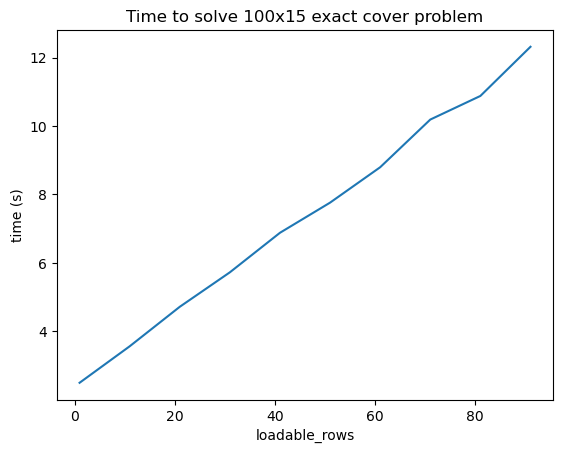

In [28]:
# Creating a random exact cover problem of size 100x15,
# plotting a line chart showing how much time it takes to solve it
# for values of loadable_rows from 1 to 100 with step 10

import matplotlib.pyplot as plt
import numpy as np
import time

N = 100
M = 15

matrix = generate_exact_cover(N, M, "generated_exact_cover.txt")

def plot_time_to_solve(matrix, loadable_rows):
    times = []
    for i in range(1, N + 1, loadable_rows):
        print(f"loadable_rows = {i}")
        # times.append(%timeit -o -q incremental_exact_cover(filename="generated_exact_cover.txt", loadable_rows=i, verbose=False).loops)
        start = time.time()
        incremental_exact_cover(filename="generated_exact_cover.txt", loadable_rows=i, verbose=False)
        end = time.time()
        times.append(end - start)
    
    plt.plot(range(1, N + 1, loadable_rows), times)
    plt.xlabel("loadable_rows")
    plt.ylabel("time (s)")
    plt.title(f"Time to solve {N}x{M} exact cover problem")
    plt.show()

plot_time_to_solve(matrix, 10)

### How do rows and columns affect the number of explored nodes?

In [29]:
# Creating different exact cover problems of rows from 20 to 100 of step 20
# and columns from 5 to 17 with step 3,
# so there are 25 different problems and each of them will have its number of explored nodes
# and its number of solutions

# Generating and solving the 25 exact cover problems
explored = []
solutions = []

row_values = range(20, 101, 20)
col_values = range(5, 18, 3)
problems = []
for rows in row_values:
    for cols in col_values:
        print(f"Generating exact cover problem with {rows} rows and {cols} columns")
        matrix = generate_exact_cover(rows, cols, "generated_exact_cover.txt")
        print("Solving...")
        sol, exp = incremental_exact_cover(filename="generated_exact_cover.txt", loadable_rows=1, verbose=False)
        explored.append((rows, cols, len(exp)))
        solutions.append((rows, cols, len(sol)))

Generating exact cover problem with 20 rows and 5 columns
Solving...
Total columns: 5
Total rows: 20
Explored: 61
Solutions: 31
Generating exact cover problem with 20 rows and 8 columns
Solving...
Total columns: 8
Total rows: 20
Explored: 214
Solutions: 19
Generating exact cover problem with 20 rows and 11 columns
Solving...
Total columns: 11
Total rows: 20
Explored: 1854
Solutions: 12
Generating exact cover problem with 20 rows and 14 columns
Solving...
Total columns: 14
Total rows: 20
Explored: 8780
Solutions: 7
Generating exact cover problem with 20 rows and 17 columns
Solving...
Total columns: 17
Total rows: 20
Explored: 67884
Solutions: 4
Generating exact cover problem with 40 rows and 5 columns
Solving...
Total columns: 5
Total rows: 40
Explored: 374
Solutions: 358
Generating exact cover problem with 40 rows and 8 columns
Solving...
Total columns: 8
Total rows: 40
Explored: 763
Solutions: 109
Generating exact cover problem with 40 rows and 11 columns
Solving...
Total columns: 11


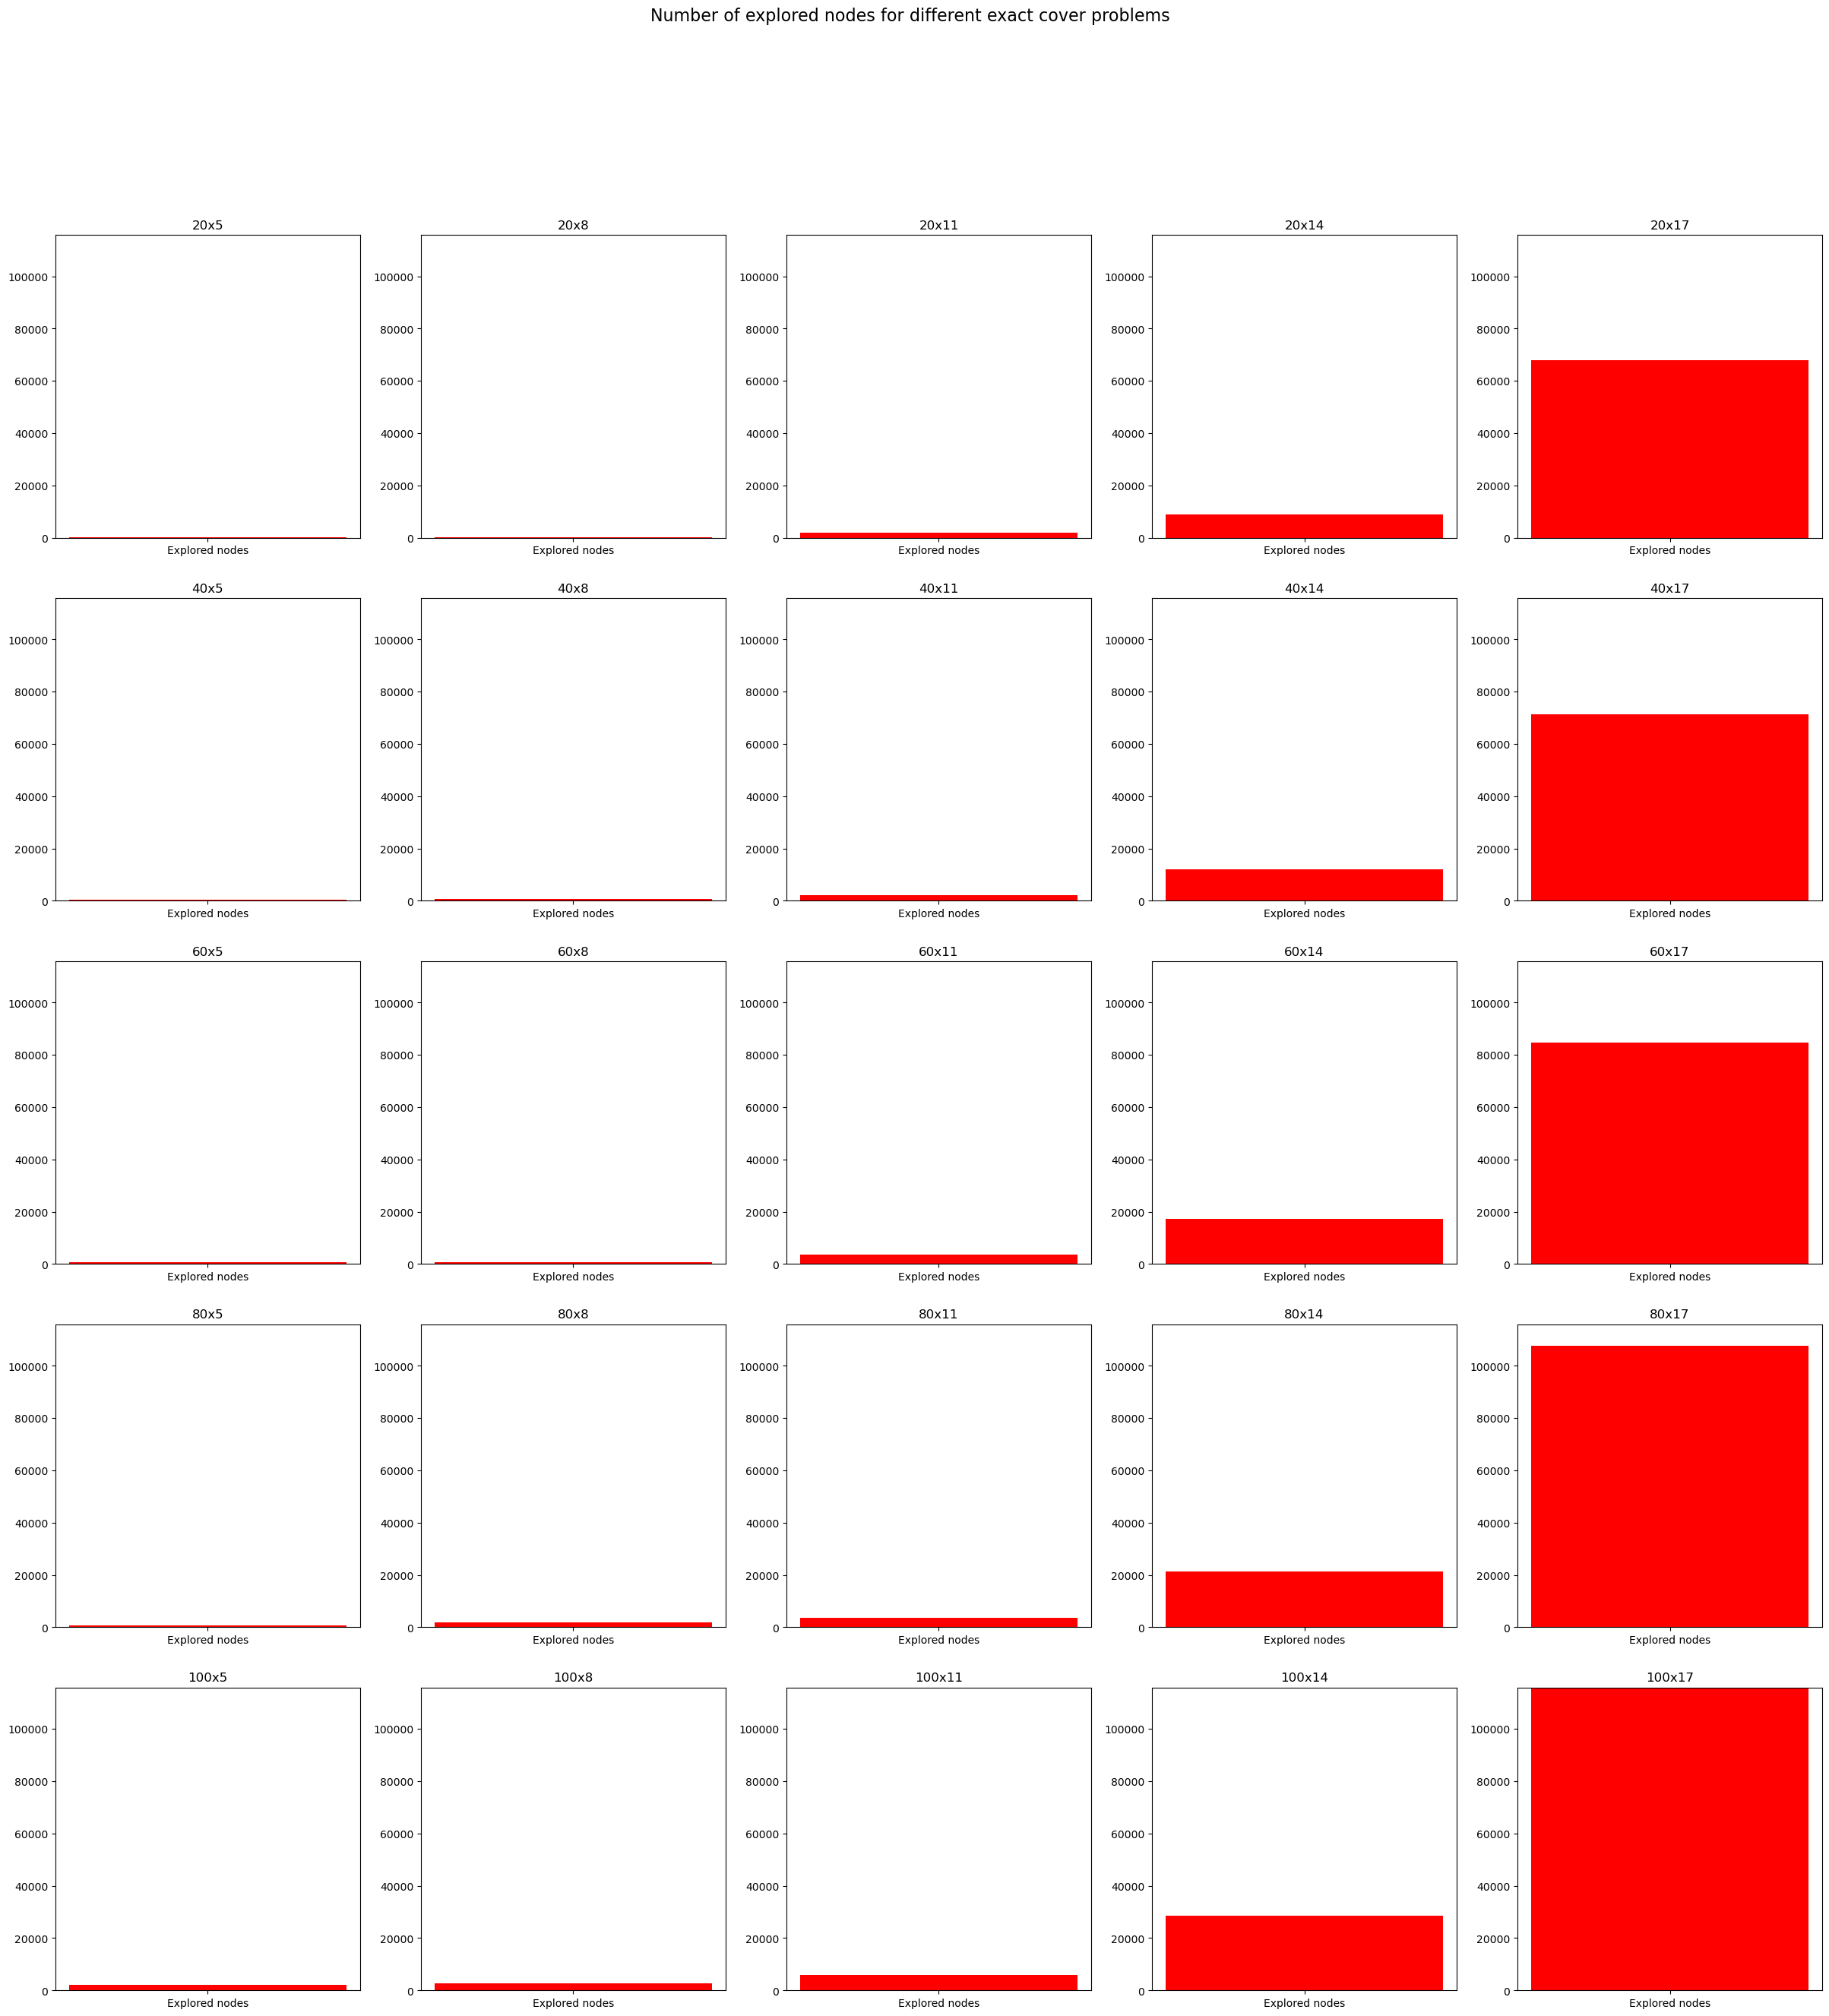

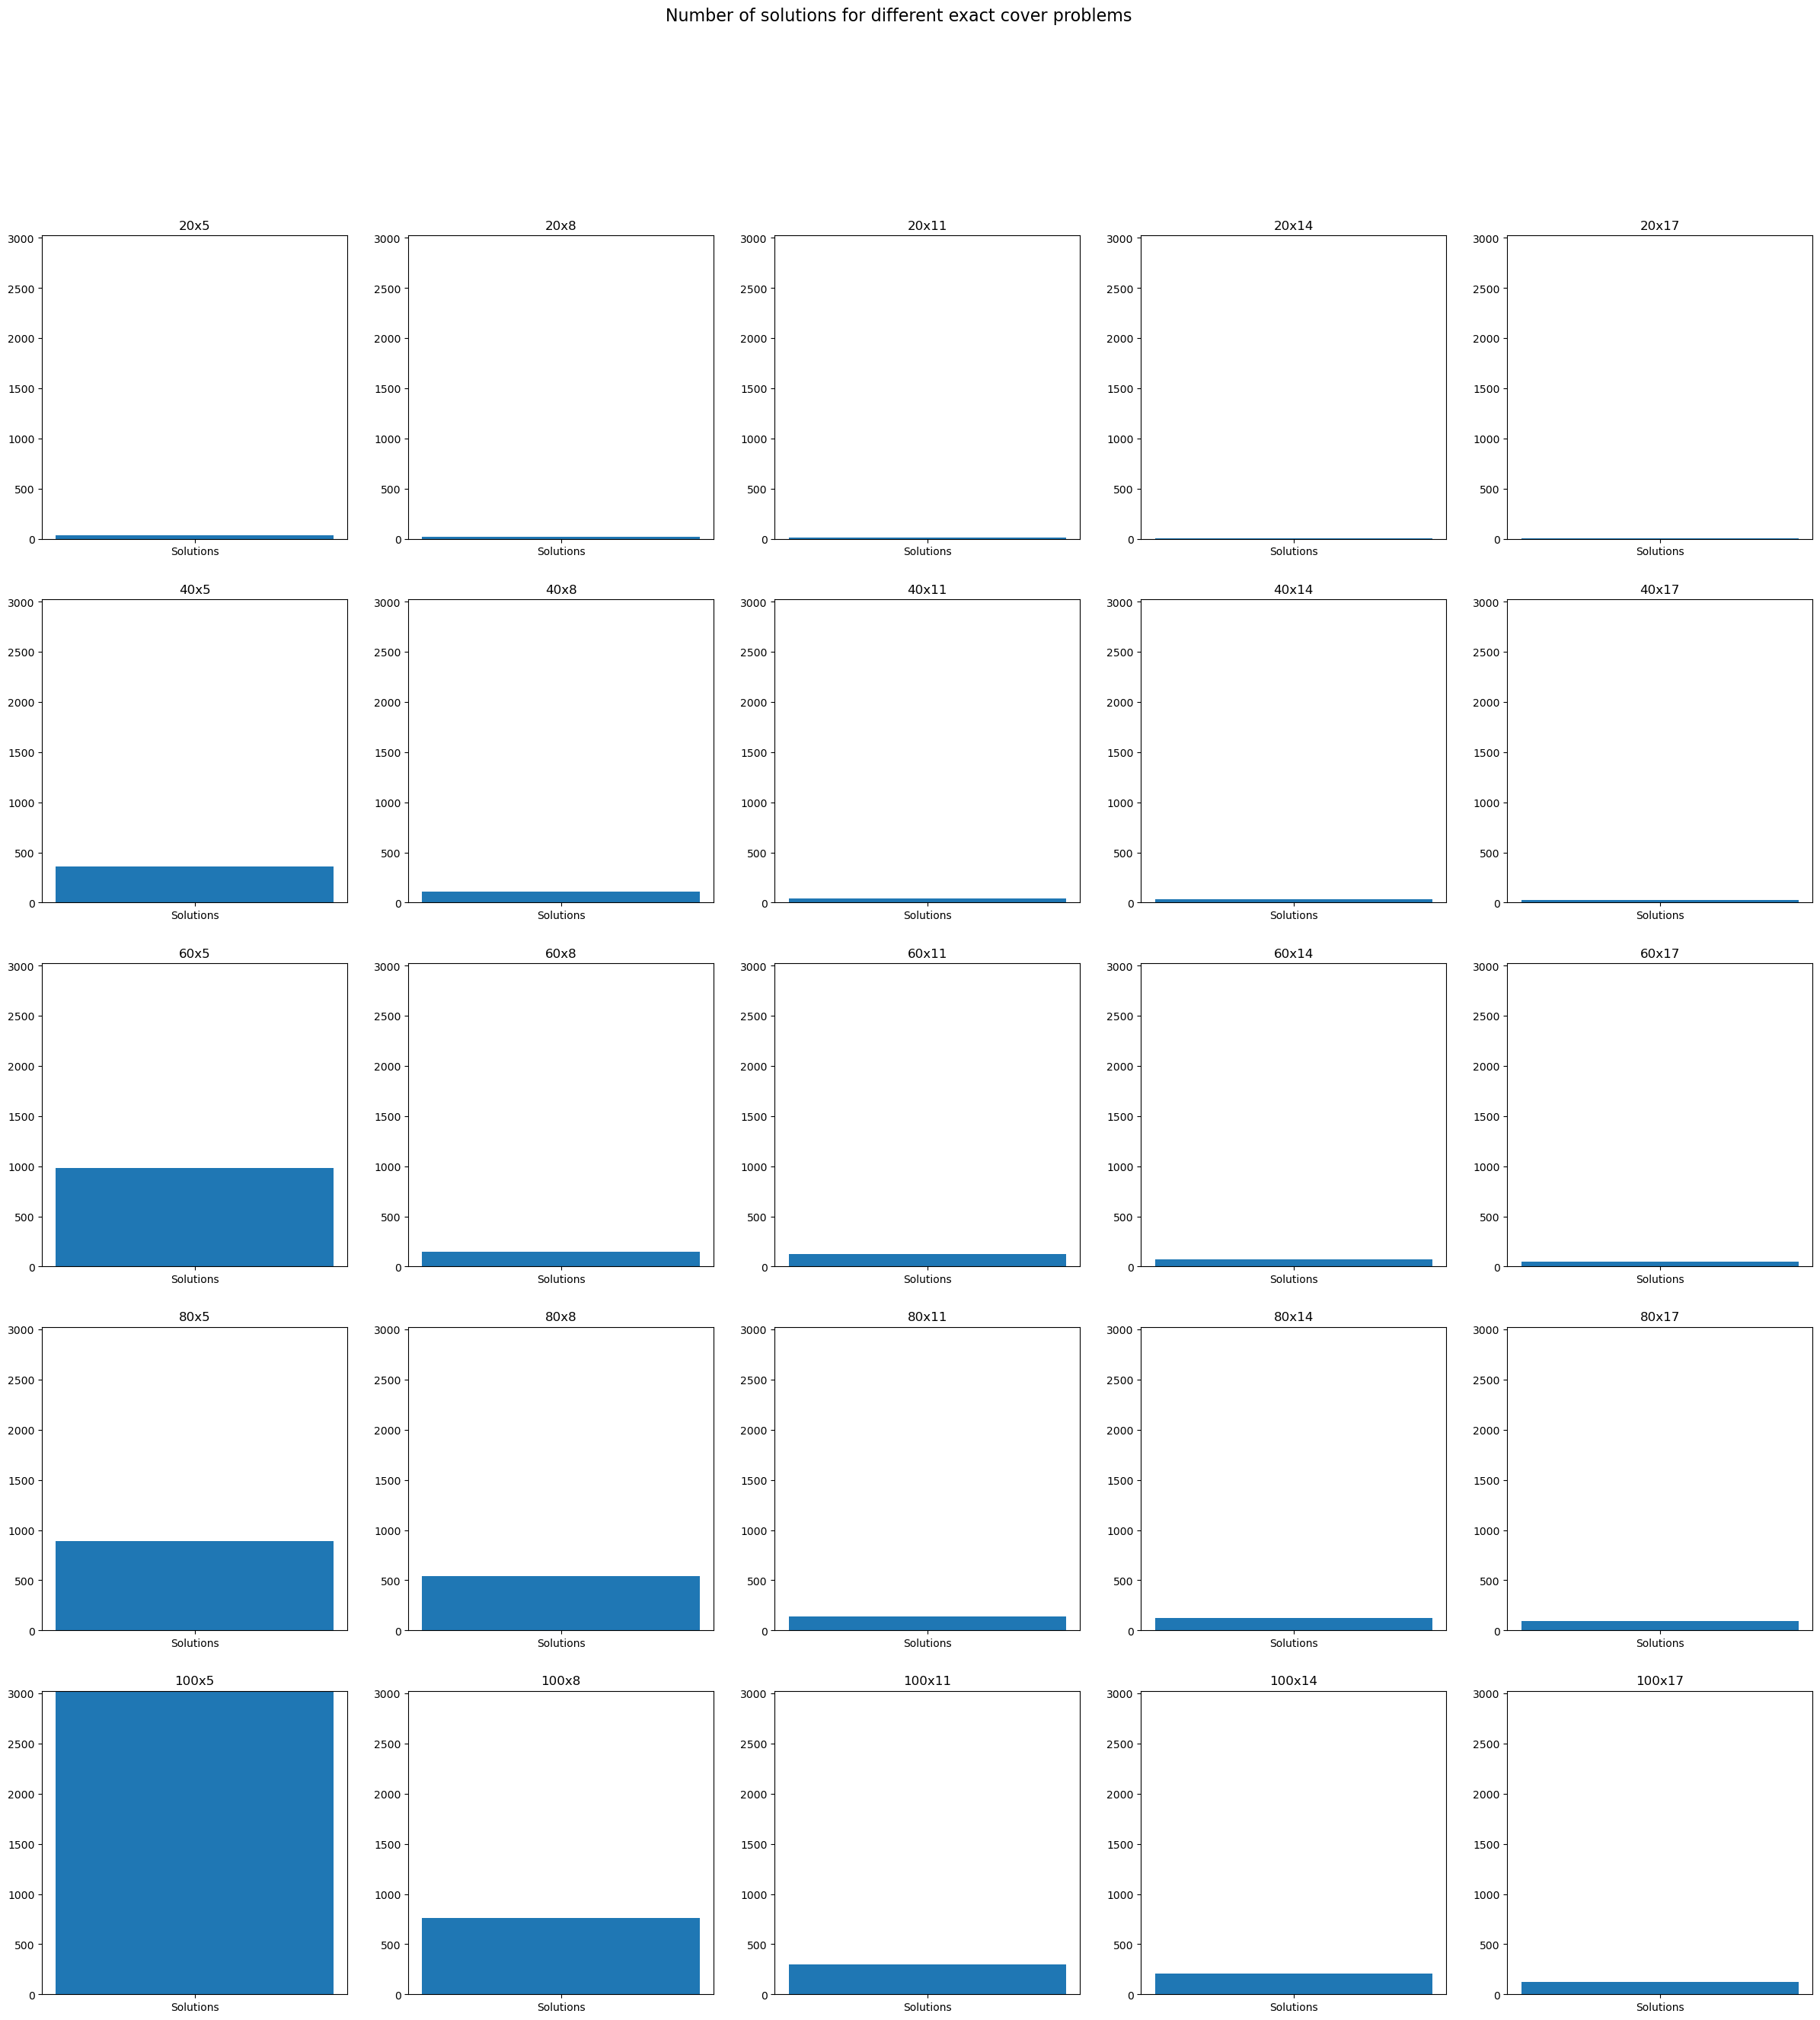

In [32]:
# Plotting the number of explored nodes
fig, axs = plt.subplots(5, 5, figsize=(30, 30))
for i, (rows, cols, exp) in enumerate(explored):
    ax = axs[i // 5][i % 5]
    # color red
    ax.bar(["Explored nodes"], [exp], color="red")
    ax.set_title(f"{rows}x{cols}")
    # ax.set_xlabel("Explored nodes")
    # ax.set_ylabel("Number of explored nodes")
    # Setting the y limit to the maximum number of explored nodes
    ax.set_ylim(top=max([exp for _, _, exp in explored]))
title = fig.suptitle("Number of explored nodes for different exact cover problems", fontsize=16)
plt.show()

# Plotting the number of solutions
fig, axs = plt.subplots(5, 5, figsize=(30, 30))
for i, (rows, cols, sol) in enumerate(solutions):
    ax = axs[i // 5][i % 5]
    ax.bar(["Solutions"], [sol])
    ax.set_title(f"{rows}x{cols}")
    # ax.set_xlabel("Solutions")
    # ax.set_ylabel("Number of solutions")
    # Setting the y limit to the maximum number of solutions
    ax.set_ylim(top=max([sol for _, _, sol in solutions]))
title = fig.suptitle("Number of solutions for different exact cover problems", fontsize=16)
plt.show()